In [1]:
# Solving the Problem Using darts library 

# 0. Oil Price Prediction

## Objective:

Oil is a product that goes completely in a different direction for a single market event as the oil prices are rarely based on real-time data, instead, it is driven by externalities making our attempt to forecast it even more challenging As the economy will be highly affected by oil prices our model will help to understand the pattern in prices to help the customers and businesses to make smart decisions.

### Sample Data Set Details:

*Extraction the data from various web sources.*

The following data is extracted from: [eia](https://www.eia.gov/)

# 1. Importing Libraries

In [2]:
# DARTS Library for Forecasting

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

# Importing the libraries

import darts
import numpy as np
import time

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import Prophet 
from darts.metrics import mase, mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper, InvertibleDataTransformer
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist, plot_pacf
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts.models import MovingAverage


from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm import tqdm

import sklearn
from sklearn import preprocessing

import pandas as pd
import torch
import matplotlib.pyplot as plt
import gc

%matplotlib inline
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

# 2. Import Data

In [3]:
# Importing data-set
df_oil = pd.read_csv('oil data update.csv')
df_oil.head(10)

,Date,Price
0,02-01-1986,25.56
1,03-01-1986,26.00
2,06-01-1986,26.53
3,07-01-1986,25.85
4,08-01-1986,25.87
5,09-01-1986,26.03
6,10-01-1986,25.65
7,13-01-1986,25.08
8,14-01-1986,24.97
9,15-01-1986,25.18


# 3.Data Manipulation

## 3.1. Conveting data to Time Seires 

In [4]:
# Oil Price
# import data 
# Convert it to timeseries

oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'Date', 
                                value_cols = ['Price'],
                                freq = 'D')

oil = oil.astype(np.float32)
oil 

/home/vmr/miniconda3/envs/project/lib/python3.9/site-packages/darts/timeseries.py:638: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  time_index = pd.DatetimeIndex(time_col_vals)


<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[11.13]],

       [[13.8 ]],

       [[  nan]],

       ...,

       [[75.19]],

       [[76.09]],

       [[78.29]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 3.1.1. Checking seasonality of the data set.

In [5]:
# Adfuller test output for stationarity of the data
check_seasonality(oil, m=None, max_lag=24, alpha=0.05)

(False, 0)

In [6]:
from matplotlib.pyplot import figure

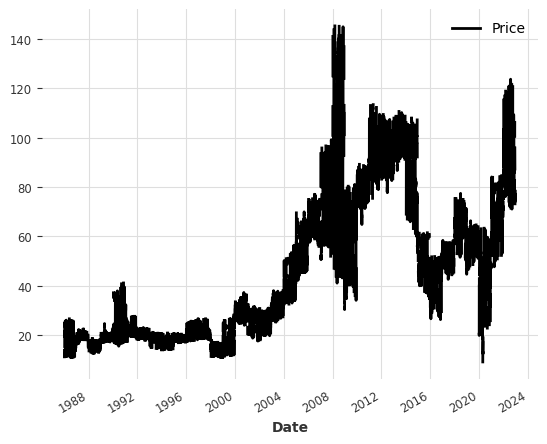

In [7]:
oil.plot()

In [8]:
# filling Missing Values
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")

In [9]:
# output after filling missing values
oil_filler

Filler

In [10]:
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

In [11]:
oil_pipeline = Pipeline([oil_filler, oil_scaler])

In [12]:
oil_pipeline

Pipeline: Filler -> Scaler

In [13]:
### Transfering data to stationary one 

In [14]:
oil_transformed = oil_pipeline.fit_transform(oil)

In [15]:
oil_transformed

<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[0.01519266]],

       [[0.03478899]],

       [[0.02961468]],

       ...,

       [[0.48535782]],

       [[0.49196327]],

       [[0.5081101 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
# Adfuller test output for stationarity of the data
check_seasonality(oil_transformed, m=None, max_lag=24, alpha=0.05)

(True, 23)

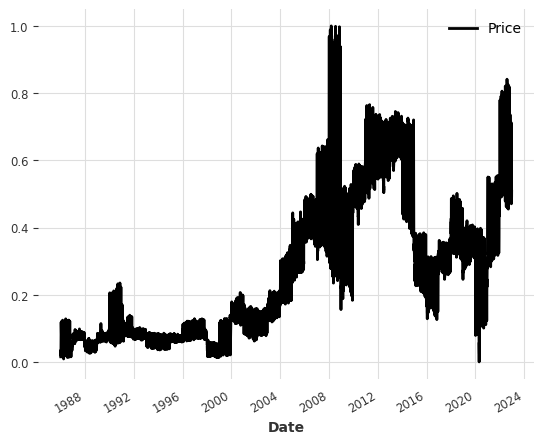

In [17]:
oil_transformed.plot()

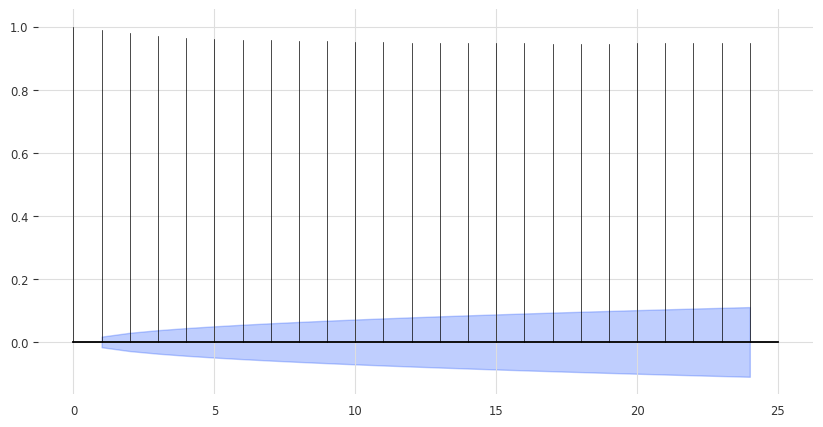

In [18]:
plot_acf(oil_transformed)

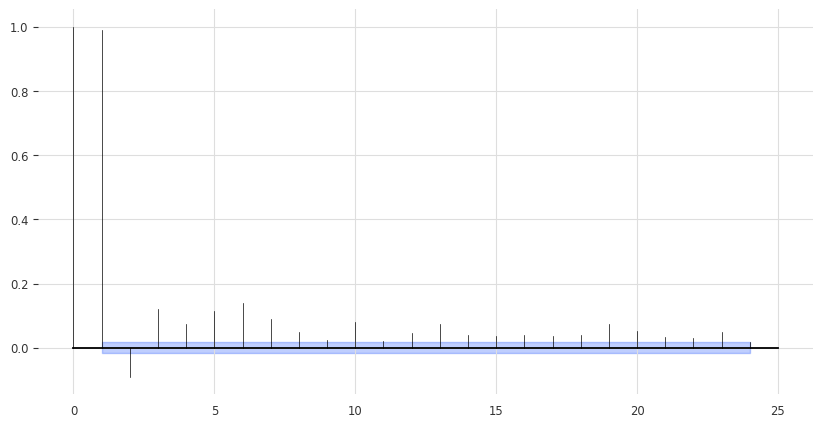

In [19]:
plot_pacf(oil_transformed)

In [20]:
final_transformed = TimeSeries.pd_dataframe(oil_transformed)

In [21]:
final_transformed
# This is the data frame of scaled and transformed data set.

component,Price
Date,
1986-01-04,0.015193
1986-01-05,0.034789
1986-01-06,0.029615
1986-01-07,0.024440
1986-01-08,0.018349
...,...
2022-12-17,0.480954
2022-12-18,0.483156
2022-12-19,0.485358


## 3.2. Inverse Transform of the data to see the final outputs

In [22]:
output = oil_pipeline.inverse_transform(oil_transformed, partial=True)

In [23]:
output

<TimeSeries (DataArray) (Date: 13501, component: 1, sample: 1)>
array([[[11.13    ]],

       [[13.8     ]],

       [[13.095001]],

       ...,

       [[75.19    ]],

       [[76.09    ]],

       [[78.29    ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

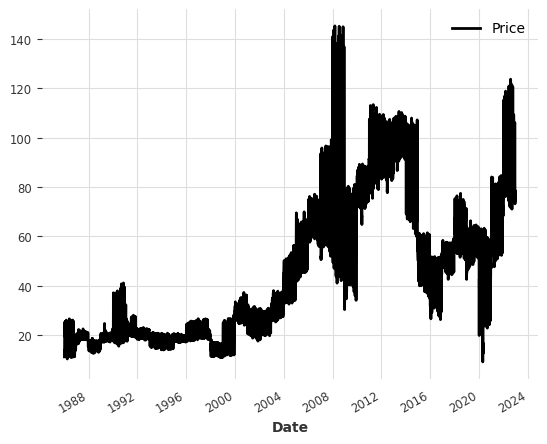

In [24]:
output.plot()

In [25]:
df_output = TimeSeries.pd_dataframe(output)

In [26]:
# Data frame of stationary data after post inverse transformation.
df_output

component,Price
Date,
1986-01-04,11.130000
1986-01-05,13.800000
1986-01-06,13.095001
1986-01-07,12.390000
1986-01-08,11.560000
...,...
2022-12-17,74.590004
2022-12-18,74.889999
2022-12-19,75.190002


In [27]:
# Transfering the data frame to csv file for futer use.
df_output.to_csv('post_transform.csv')

# 4. Moving Averages of the data 

In [28]:
# Moving Averages for Oil Price for 7 days
oil_moving_average_7 = MovingAverage(window=7)

In [29]:
# Moving Averages for Oil Price for 28 days
oil_moving_average_28 = MovingAverage(window=28)

In [30]:
oil_moving_averages = []

In [31]:
ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)

In [32]:
ma_7.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.02600917]],

       [[0.02447706]],

       [[0.0257003 ]],

       [[0.02849803]],

       [[0.0328283 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) <U20 'rolling_mean_7_Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [33]:
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")

In [34]:
ma_7.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.02600917]],

       [[0.02447706]],

       [[0.0257003 ]],

       [[0.02849803]],

       [[0.0328283 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_7'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)

In [36]:
ma_28.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06141546]],

       [[0.06407502]],

       [[0.06605045]],

       [[0.06746249]],

       [[0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) <U21 'rolling_mean_28_Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [37]:
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")

In [38]:
ma_28.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06141546]],

       [[0.06407502]],

       [[0.06605045]],

       [[0.06746249]],

       [[0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [39]:
oil_moving_averages = ma_7.stack(ma_28)

In [40]:
oil_moving_averages.head()

<TimeSeries (DataArray) (Date: 5, component: 2, sample: 1)>
array([[[0.02600917],
        [0.06141546]],

       [[0.02447706],
        [0.06407502]],

       [[0.0257003 ],
        [0.06605045]],

       [[0.02849803],
        [0.06746249]],

       [[0.0328283 ],
        [0.06842405]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 1986-01-08
  * component  (component) object 'oil_ma_7' 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 4.1. Moving Average plots

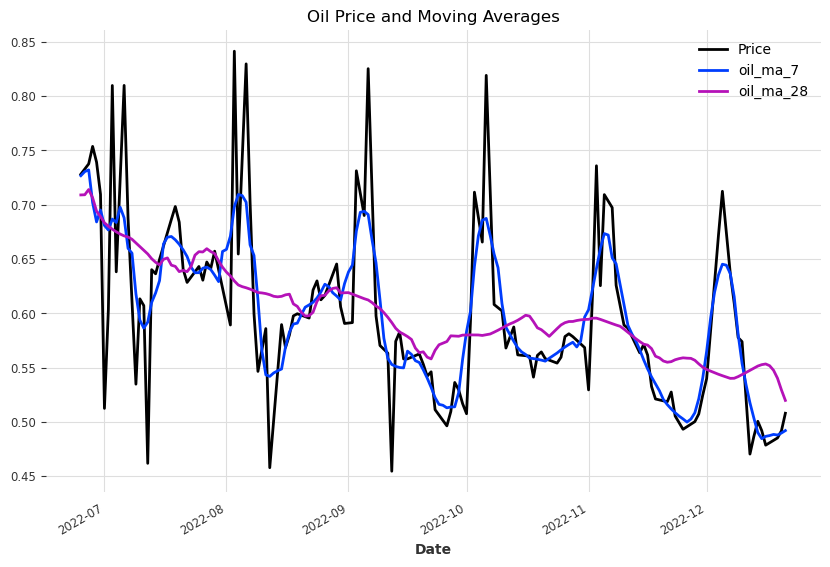

In [41]:
plt.figure(figsize=(10, 6))
oil_transformed[-180:].plot()
oil_moving_averages[-180:].plot()
plt.title("Oil Price and Moving Averages");

In [42]:
output.to_csv('post_data_conversion.csv')

In [43]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13501 entries, 1986-01-04 to 2022-12-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   13501 non-null  float32
dtypes: float32(1)
memory usage: 158.2 KB


In [44]:
# Adfuller test output for stationarity of the data
check_seasonality(output, m=None, max_lag=24, alpha=0.05)

(True, 23)

# 5. Splitting data set (for train and validation)

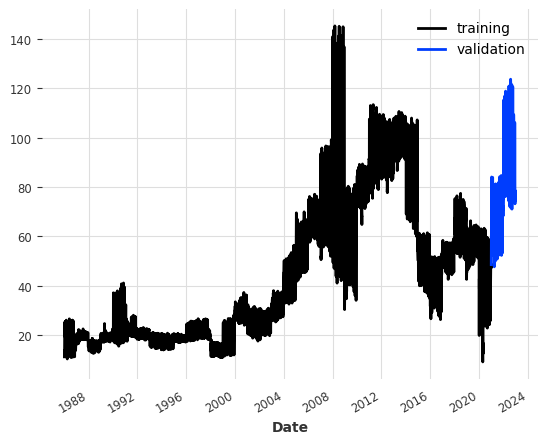

In [45]:
train, val = output.split_before(pd.Timestamp('2020-12-31'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [46]:
# Training Dataset
train

<TimeSeries (DataArray) (Date: 12780, component: 1, sample: 1)>
array([[[11.13    ]],

       [[13.8     ]],

       [[13.095001]],

       ...,

       [[47.62    ]],

       [[48.      ]],

       [[48.4     ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-04 1986-01-05 ... 2020-12-30
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [47]:
# Validation Dataset
val

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[ 48.52    ]],

       [[ 51.035   ]],

       [[ 53.55    ]],

       [[ 60.64    ]],

       [[ 61.45    ]],

       [[ 64.585   ]],

       [[ 67.72    ]],

       [[ 75.23    ]],

       [[ 71.91001 ]],

       [[ 68.59    ]],

...

       [[ 73.17    ]],

       [[ 75.39    ]],

       [[ 77.28    ]],

       [[ 76.11    ]],

       [[ 74.29    ]],

       [[ 74.590004]],

       [[ 74.89    ]],

       [[ 75.19    ]],

       [[ 76.09    ]],

       [[ 78.29    ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [48]:
df_train = TimeSeries.pd_dataframe(train)
df_train

component,Price
Date,
1986-01-04,11.130000
1986-01-05,13.800000
1986-01-06,13.095001
1986-01-07,12.390000
1986-01-08,11.560000
...,...
2020-12-26,47.924995
2020-12-27,47.772499
2020-12-28,47.619999


In [49]:
df_val = TimeSeries.pd_dataframe(val)
df_val

component,Price
Date,
2020-12-31,48.520000
2021-01-01,51.035000
2021-01-02,53.549999
2021-01-03,60.639999
2021-01-04,61.450001
...,...
2022-12-17,74.590004
2022-12-18,74.889999
2022-12-19,75.190002


# 6. Prophet

In [50]:
# from darts.models Arima building
model5 = Prophet()
model5.fit(train)
prediction5 = model5.predict(len(val))

14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:37 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
prediction5

<TimeSeries (DataArray) (Date: 721, component: 1, sample: 1)>
array([[[37.41053468]],

       [[37.3908607 ]],

       [[37.40021098]],

       [[37.48374543]],

       [[37.61431181]],

       [[37.48892197]],

       [[37.53009629]],

       [[37.63135662]],

       [[37.57308983]],

       [[37.53890513]],

...

       [[25.99253184]],

       [[25.77924222]],

       [[25.74408215]],

       [[25.78205335]],

       [[25.67474362]],

       [[25.60665439]],

       [[25.62456686]],

       [[25.70268936]],

       [[25.53909929]],

       [[25.55706055]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-12-31 2021-01-01 ... 2022-12-21
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [52]:
df_prediction5 = TimeSeries.pd_dataframe(prediction5)
df_prediction5

component,Price
Date,
2020-12-31,37.410535
2021-01-01,37.390861
2021-01-02,37.400211
2021-01-03,37.483745
2021-01-04,37.614312
...,...
2022-12-17,25.606654
2022-12-18,25.624567
2022-12-19,25.702689


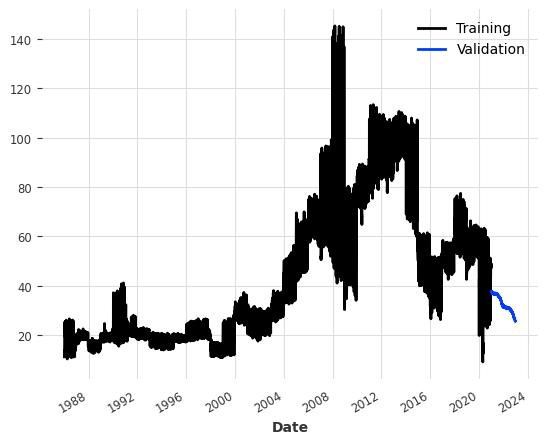

In [53]:
train.plot(label='Training')
prediction5.plot(label='Validation')
plt.legend();

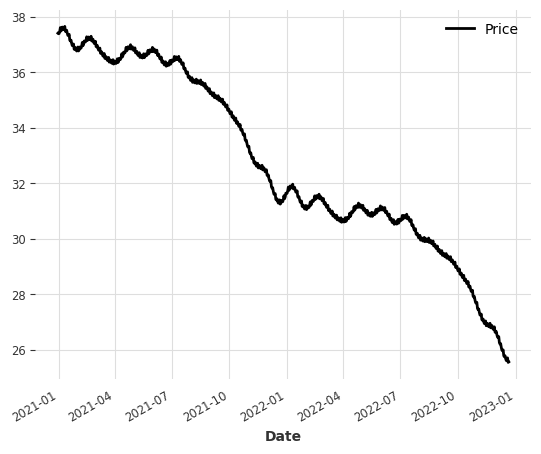

In [54]:
prediction5.plot()

In [55]:
# Converting arima model prediction to a data frame
df_prediction5 = TimeSeries.pd_dataframe(prediction5)
df_prediction5

component,Price
Date,
2020-12-31,37.410535
2021-01-01,37.390861
2021-01-02,37.400211
2021-01-03,37.483745
2021-01-04,37.614312
...,...
2022-12-17,25.606654
2022-12-18,25.624567
2022-12-19,25.702689


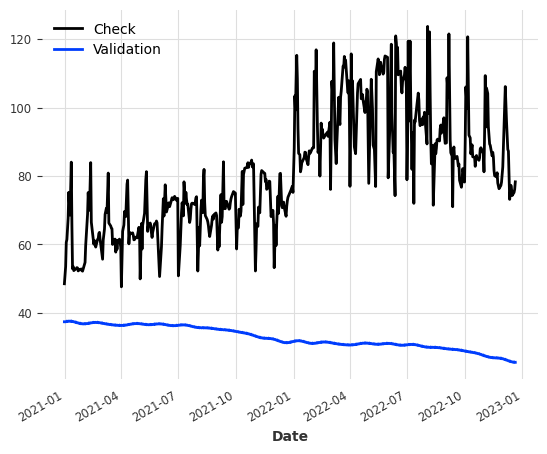

In [56]:
val.plot(label='Check')
prediction5.plot(label='Validation')
plt.legend();

### 6.5.1. Model Evaluation

In [57]:
score_model5_mape = mape(val, prediction5)
score_model5_mape

57.19020218046133

In [58]:
score_model5_mase = mase(val, prediction5 ,train)
score_model5_mase

28.15413887745821

In [60]:
import pickle as pkl 

In [61]:
# Dump the model to disk using pickle
filename = 'model5.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model5, file)